<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
dark_mode = True

In [2]:
import numpy as np, matplotlib.pyplot as plt, matplotlib as mpl, seaborn as sns
import pandas as pd
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

import pcmdpy as ppy
%matplotlib inline

GPU acceleration not available, sorry
No module named 'pycuda'


In [3]:
try:
    ppy.gpu_utils.initialize_gpu(n=0)
    GPU_AVAIL = True
except:
    GPU_AVAIL = False

In [4]:
fig_dir = '../../talks/figures/'
if dark_mode:
    plt.style.use('dark_background')
    fig_dir = '../../talks/figures_dark/'

In [5]:
plt.style.use('seaborn-poster')

In [6]:
f = ppy.instrument.default_m31_filters()
iso_model = ppy.isochrones.Isochrone_Model(f)
driv = ppy.driver.Driver(iso_model, gpu=GPU_AVAIL)

In [7]:
pcmd_m31_b = np.loadtxt('../data/m31_bulge_M2.dat', unpack=True)
pcmd_m31_d = np.loadtxt('../data/m31_b06-263.dat', unpack=True)


In [8]:
files = ['../data/h_m51_i_s05_drz_sci.fits', '../data/h_m51_v_s05_drz_sci.fits', '../data/h_m51_b_s05_drz_sci.fits']
filts = ppy.instrument.m51_filters
m51 = ppy.utils.DataSet(files, filts)
for f in m51.filters:
    f._exposure /= 6.  # Exposure is miscalculated in FITS files

In [9]:
f_m51 = m51.filters
dmod_m51 = 25. + 5.*np.log10(8.58)

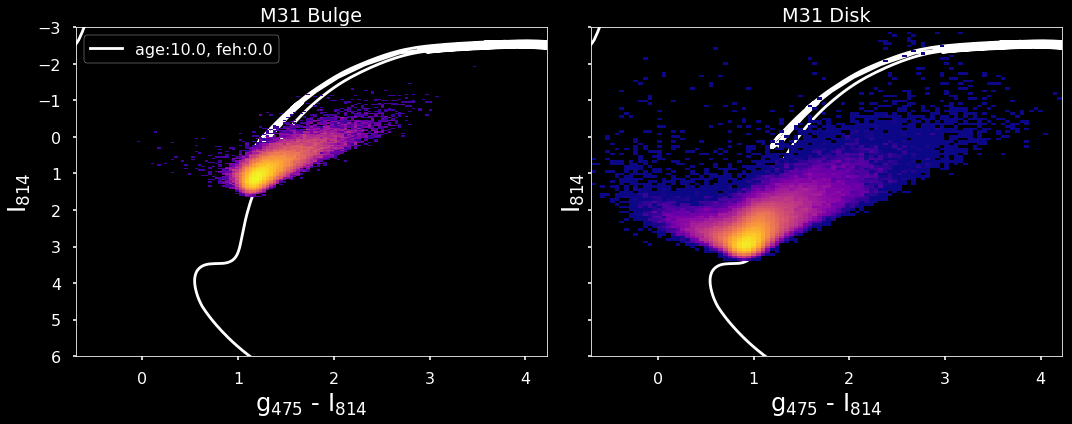

In [10]:
norm = mpl.colors.LogNorm(vmin=5e-3)
fig, axes = plt.subplots(ncols=2, figsize=(15, 6), sharex=True, sharey=True)
_ = ppy.plotting.plot_pcmd(pcmd_m31_b, title='M31 Bulge', ax=axes[0], norm=norm, hist2d_kwargs={'cmap':'plasma', 'normed':True})
ppy.plotting.plot_isochrone(iso_model, dmod=0., axes=axes[0], system='ab', zorder=-1, color='w')
_ = ppy.plotting.plot_pcmd(pcmd_m31_d, title='M31 Disk', ax=axes[1], norm=norm, hist2d_kwargs={'cmap':'plasma', 'normed':True})
ppy.plotting.plot_isochrone(iso_model, dmod=0., axes=axes[1], system='ab', zorder=-1, color='w')
axes[0].set_ylim([6, -3.])
axes[0].legend(loc=0)
axes[0].set_xlabel(axes[0].get_xlabel(), fontsize=24)
axes[0].set_ylabel(axes[0].get_ylabel(), fontsize=24)
axes[1].set_xlabel(axes[1].get_xlabel(), fontsize=24)
axes[1].set_ylabel(axes[1].get_ylabel(), fontsize=24)
plt.tight_layout()
plt.savefig(fig_dir + 'm31_pcmds.pdf', bbox_inches='tight')

In [11]:
iso_model_m51 = ppy.isochrones.Isochrone_Model(f_m51)
driv_m51 = ppy.driver.Driver(iso_model_m51, gpu=GPU_AVAIL)

In [12]:
def read_region(ds9_line):
    try:
        data, comments = ds9_line.split(' #')
    except ValueError:
        return None, None, None
    if not data.startswith('box'):
        return None, None, None
    x, y, dx, dy, _ = [float(s) for s in data.lstrip('box(').rstrip(')').split(',')]
    xlim = [x-dx/2, x+dx/2]
    ylim = [y-dy/2, y+dy/2]
    if 'text=' in comments:
        name = comments.split('text={')[-1].split('}')[0]
    else:
        name = ''
    return xlim, ylim, name

In [13]:
regions = {}
with open('../data/m51_regions_detector.reg', 'r') as my_file:
    lines = my_file.readlines()
    for line in lines:
        xlim, ylim, name = read_region(line)
        if name is not None:
            regions[name.lower()] = (xlim, ylim)

In [14]:
def add_region(xlim, ylim, ax, title=None, **kwargs):
    dx = np.diff(xlim)[0]
    dy = np.diff(ylim)[0]
    kwargs['color'] = kwargs.get('color', 'r')
    kwargs['lw'] = kwargs.get('lw', 2)
    kwargs['fill'] = kwargs.get('fill', False)
    r = ax.add_patch(mpl.patches.Rectangle((xlim[0], ylim[0]), dx, dy, **kwargs))
    if title is not None:
        ax.text(xlim[0], ylim[1]+0.1*dy, title, color=kwargs['color'],
                verticalalignment='bottom', horizontalalignment='left', fontsize=16)
    return r

In [17]:
I_sky = f_m51[0].counts_to_mag(82.)

In [18]:
def full_clip(percentile):
    return np.array([np.percentile(im_full[:,:,i], percentile) for i in range(3)])

In [19]:
X, Y = np.meshgrid(np.arange(m51.im_shape[1]), np.arange(m51.im_shape[0]))

In [20]:
def make_bools(xlim, ylim):
    return (xlim[0] <= X) & (X < xlim[1]) & (ylim[0] <= Y) & (Y < ylim[1])

In [21]:
bools = {}
for k, (xlim, ylim) in regions.items():
    bools[k] = make_bools(xlim, ylim)

In [22]:
pcmds = {}
for k, b in bools.items():
    pcmds[k] = m51.get_pcmd(b)

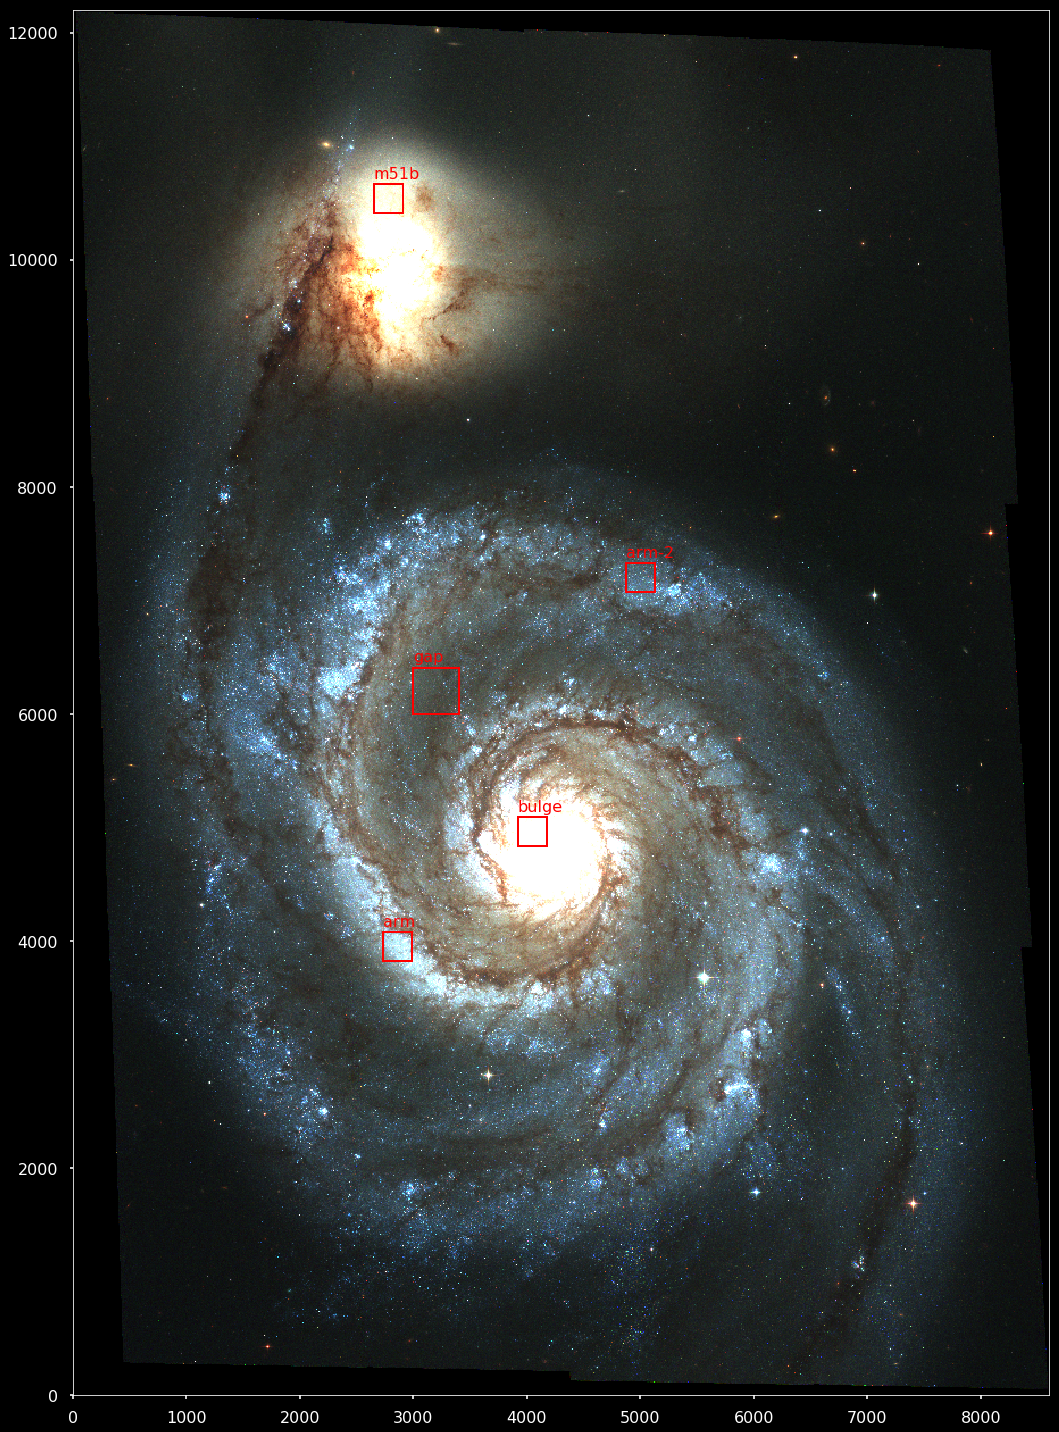

In [23]:
fig, ax = plt.subplots(figsize=(15, 20))
im_full, extent = m51.get_image(downsample=10)
_ = ppy.plotting.plot_rgb_image(im_full, extent=extent, ax=ax)
for r, (xlim, ylim) in regions.items():
    add_region(xlim, ylim, ax, title=r)
plt.tight_layout()
# plt.savefig('figures/M51_with_regions.pdf')
plt.savefig(fig_dir + 'M51_with_regions.jpg', bbox_inches='tight')

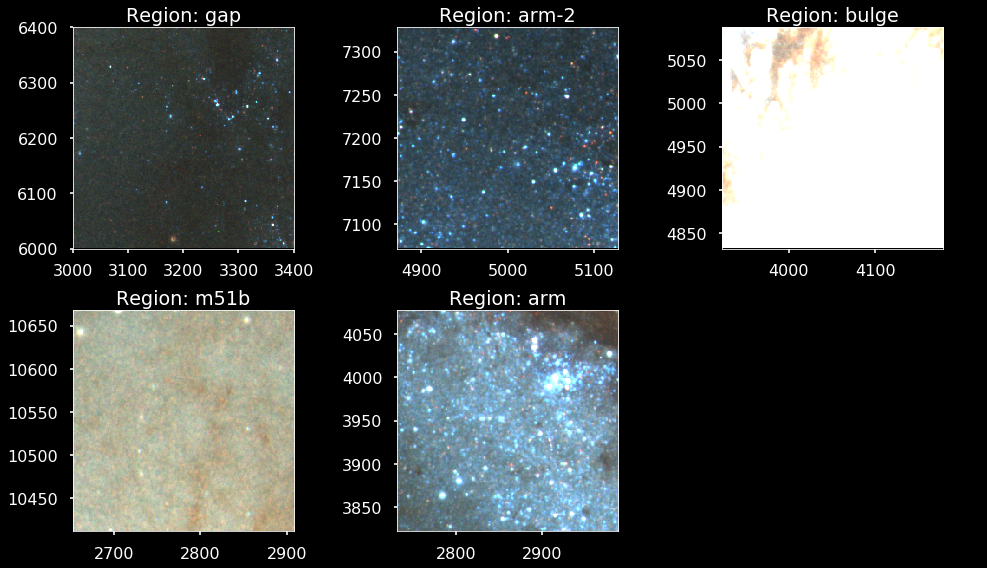

In [24]:
ims = {}
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(14, 8))
for k, ax in zip(bools.keys(), axes.flatten()):
    ims[k], extent = m51.get_image(bools[k], downsample=1)
    ax = ppy.plotting.plot_rgb_image(ims[k], extent=extent, ax=ax, clip_vals=full_clip(99.))
    ax.set_title('Region: {:s}'.format(k))
axes[1,2].axis('off')
plt.tight_layout()

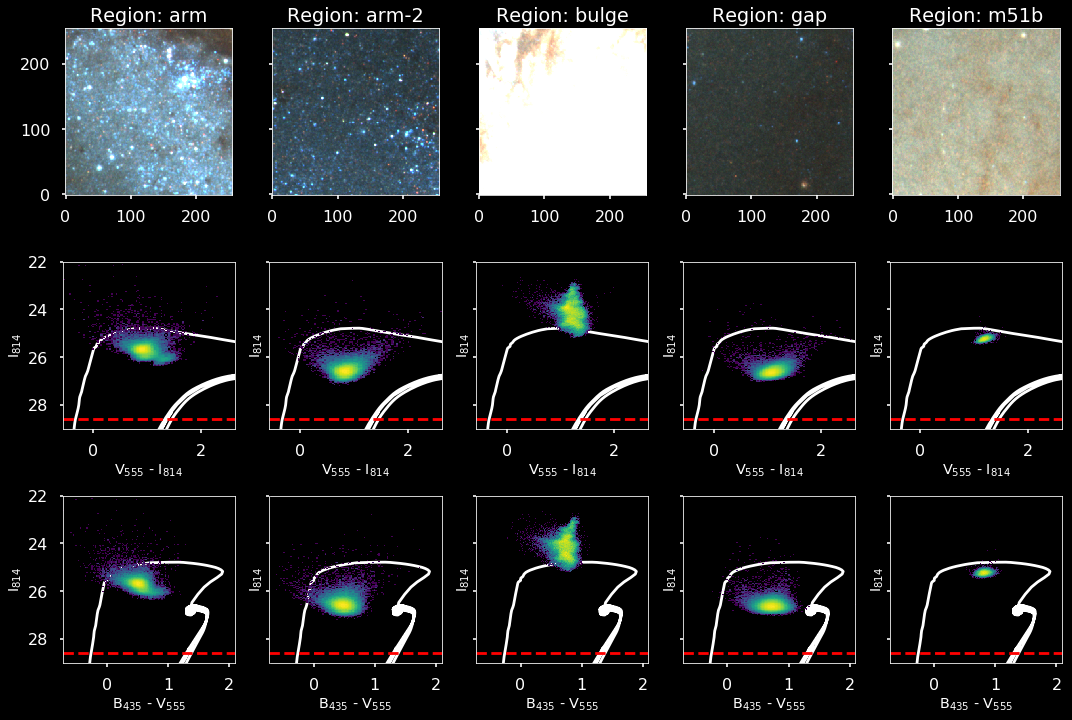

In [25]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10), sharex='row', sharey='row')
for i, k in enumerate(sorted(pcmds.keys())):
    ppy.plotting.plot_rgb_image(ims[k], ax=axes[0,i], clip_vals=full_clip(99.))
    ppy.plotting.plot_pcmd(pcmds[k][:2], bins=100, ax=axes[1,i])
    ppy.plotting.plot_pcmd(pcmds[k][::2], bins=100, ax=axes[2,i])
    ppy.plotting.plot_isochrone(iso_model_m51, dmod=dmod_m51, axes=axes[1:, i],
                                zorder=-1, color='w')
    axes[0,i].set_title('Region: {:s}'.format(k))
    axes[1,i].axhline(y=I_sky, ls='--', color='r')
    axes[2,i].axhline(y=I_sky, ls='--', color='r')
axes[1,0].set_ylim([29, 22]), axes[2,0].set_ylim([29, 22])
plt.tight_layout()
plt.savefig(fig_dir + 'm51_regions.pdf', bbox_inches='tight')

In [26]:
results = {}

In [27]:
results['IVB'] = ppy.plotting.ResultsPlotter('results/m51_gap_tau_IVB.csv', run_name='M51 Gap - I,V,B bands')

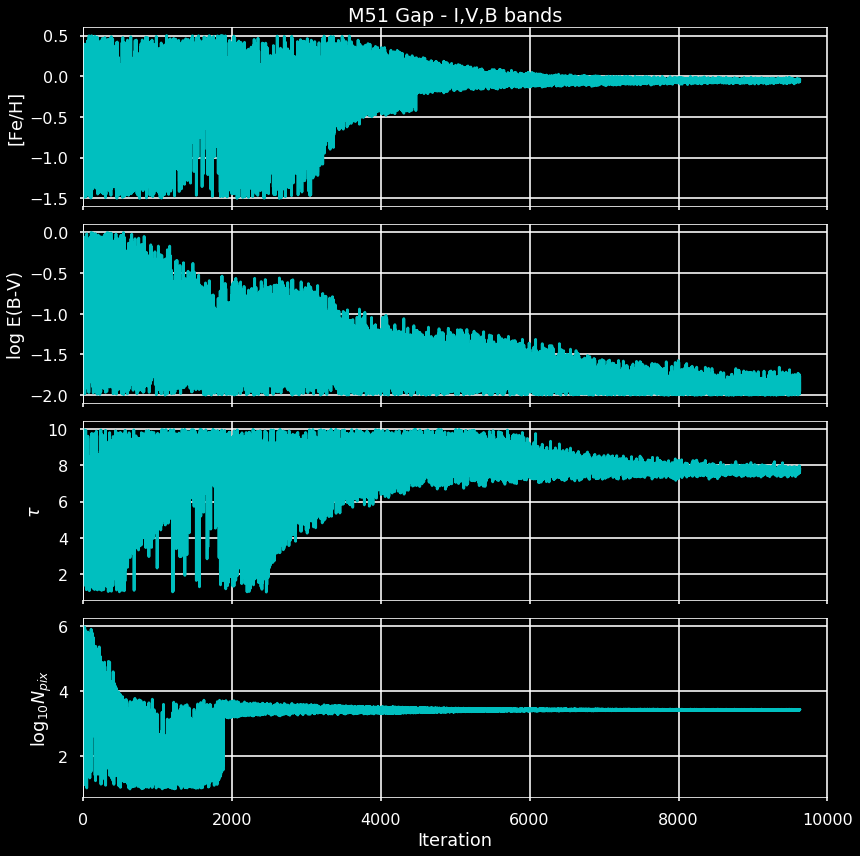

In [50]:
fix, axes = plt.subplots(nrows=4, figsize=(12, 12), sharex=True, sharey='row')
results['IVB'].plot_chains(axes=axes, chains_only=True, plot_kwargs={'color':'c'})
axes[0].set_xlim([0, 10000])
for ax in axes.flatten():
    ax.grid(True)
plt.tight_layout()
plt.savefig(fig_dir + 'm51_gap_chains.jpg', bbox_inches='tight')

In [ ]:
fig, axes = results['IVB'].plot_corner(weight=False, burn=4000, bins=30, color='c');
for ax in axes.flatten():
    ax.grid(True)
plt.savefig(fig_dir + 'm51_gap_corner.pdf', bbox_inches='tight')